Decimating with K=0.02, corresponding to resolution 4.0
8.874092e-06
Decimating with K=0.08, corresponding to resolution 16.0
2.5184183e-05
Decimating with K=0.8, corresponding to resolution 160.0
0.0007054097


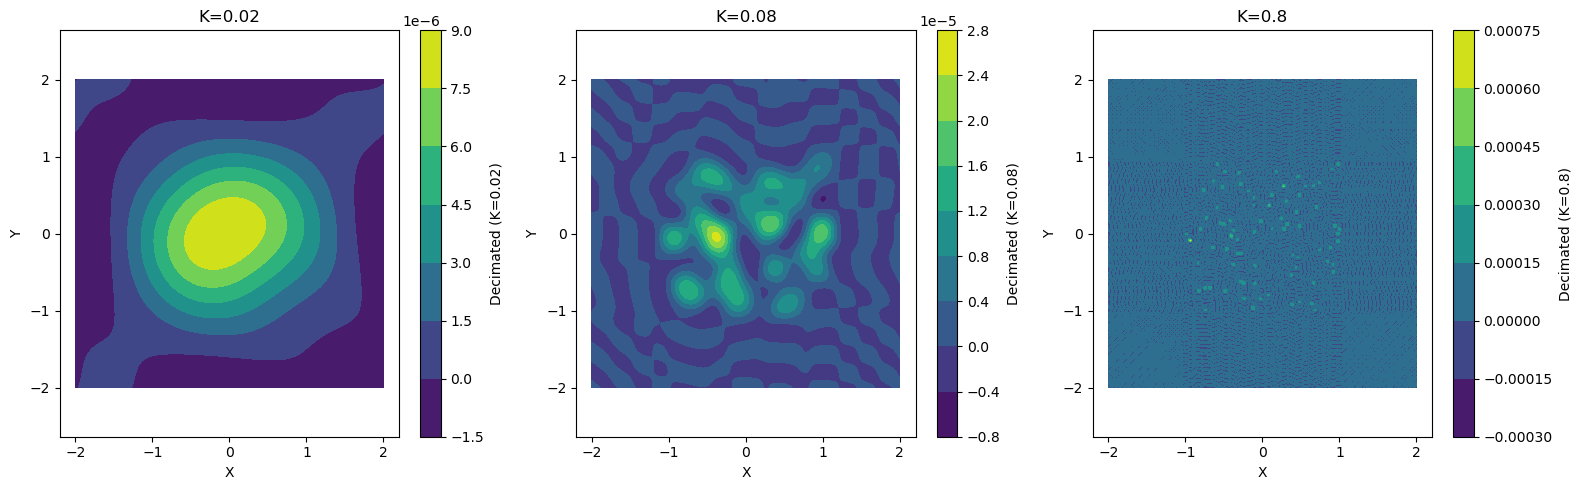

Decimating with K=0.02, corresponding to resolution 4.0
0.00022983011
Decimating with K=0.08, corresponding to resolution 16.0
0.0011612822
Decimating with K=0.8, corresponding to resolution 160.0
0.0032160387


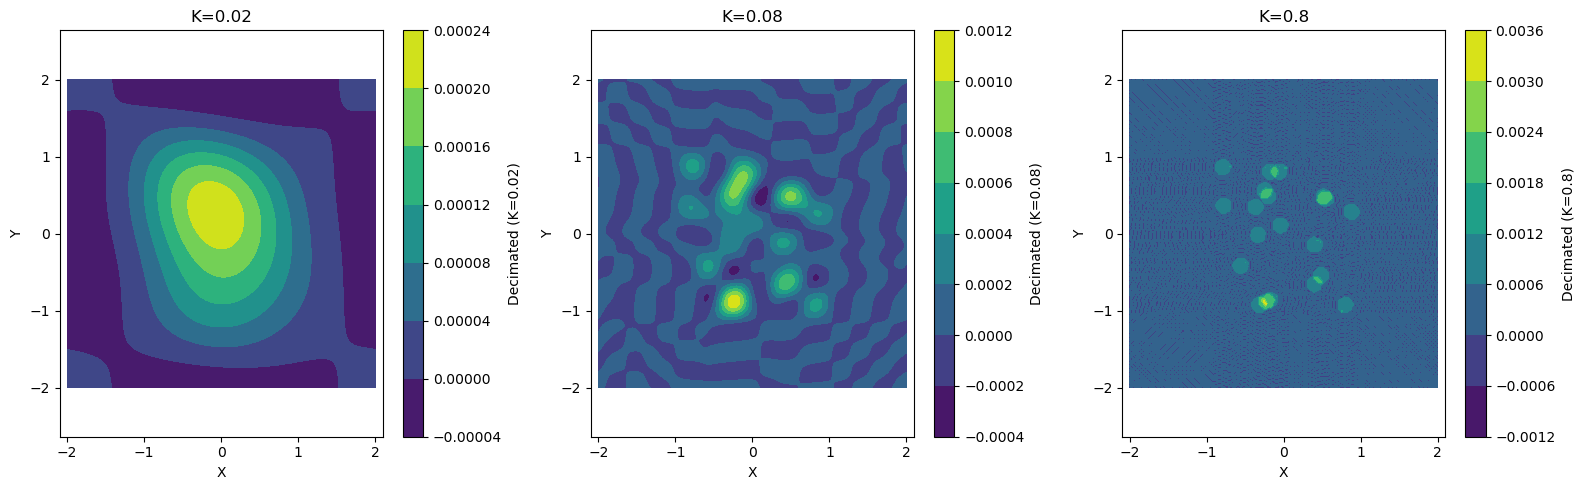

Decimating with K=0.02, corresponding to resolution 4.0
0.025253672
Decimating with K=0.08, corresponding to resolution 16.0
0.022863843
Decimating with K=0.8, corresponding to resolution 160.0
0.034458555


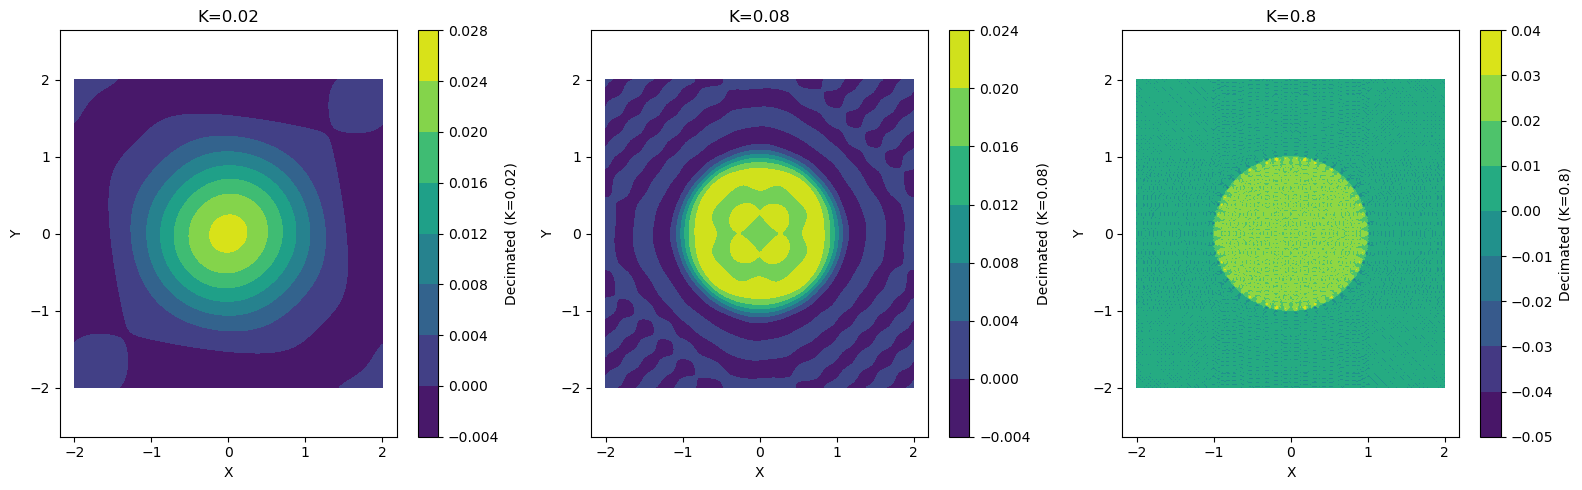

In [10]:
import jax.numpy as jnp
from jax import random, vmap
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Define the average of inverse distances function
def average_inverse_distance(points, weights, grid_points):
    """
    Computes the average of the inverse distances from each grid point to a set of 2D points.

    Args:
        points: An array of shape (N, 2) representing the set of 2D points.
        grid_points: An array of shape (M, 2) representing the grid of 2D points.

    Returns:
        An array of shape (M,) containing the average of the inverse distances for each grid point.
    """
    def compute_inverse_distance(grid_point):
        distances = jnp.sqrt(jnp.sum((points - grid_point) ** 2, axis=1))
        #inverse_distances = 1 / (distances + 1e-8)  # Adding a small epsilon to avoid division by zero
        distances = jnp.exp(-distances/0.02) * weights
        return jnp.mean(distances)

    return vmap(compute_inverse_distance)(grid_points)


def indicator_function(points, normals, weights, grid_points):
    """
    Computes the average of the inverse distances from each grid point to a set of 2D points.

    Args:
        points: An array of shape (N, 2) representing the set of 2D points.
        grid_points: An array of shape (M, 2) representing the grid of 2D points.

    Returns:
        An array of shape (M,) containing the average of the inverse distances for each grid point.
    """
    def compute_indicator(grid_point):
        dpoint = points - grid_point
        distances = jnp.sqrt(jnp.sum(dpoint ** 2, axis=1))
        normal_dots = jnp.sum(normals * dpoint, axis=1)
        #inverse_distances = 1 / (distances + 1e-8)  # Adding a small epsilon to avoid division by zero
        distances = normal_dots / distances**2 * weights
        return jnp.mean(distances)

    return vmap(compute_indicator)(grid_points)

# Generate random circles and sample points on their boundaries
def generate_circle_points(center, radius, num_points):
    """
    Generates points on the boundary of a circle.

    Args:
        center: A tuple (x, y) representing the center of the circle.
        radius: Radius of the circle.
        num_points: Number of points to generate on the circle boundary.

    Returns:
        An array of shape (num_points, 2) containing the points on the circle boundary.
    """
    angles = jnp.linspace(0, 2 * jnp.pi, num_points, endpoint=False)
    x = center[0] + radius * jnp.cos(angles)
    y = center[1] + radius * jnp.sin(angles)
    return jnp.stack([x, y], axis=1)


def generate_circle_normals(num_points):
    """
    Generates normals to the boundary of a circle.

    Args:
        center: A tuple (x, y) representing the center of the circle.
        radius: Radius of the circle.
        num_points: Number of points to generate on the circle boundary.

    Returns:
        An array of shape (num_points, 2) containing the normals to the circle boundary.
    """
    angles = jnp.linspace(0, 2 * jnp.pi, num_points, endpoint=False)
    x = jnp.cos(angles)
    y = jnp.sin(angles)
    return jnp.stack([x, y], axis=1)

# Function to decimate high frequencies
def decimate_fourier(data, K):
    """
    Decimates high frequencies in the 2D Fourier transform of the data.

    Args:
        data: 2D array to be transformed.
        K: Cutoff frequency for decimation (fraction of frequencies to retain).

    Returns:
        2D array with high frequencies removed.
    """
    fft_data = fft2(data)
    fft_data_shifted = fftshift(fft_data)

    # Create a mask to retain low frequencies
    rows, cols = data.shape
    crow, ccol = rows // 2, cols // 2
    mask = jnp.zeros_like(data, dtype=bool)
    mask = mask.at[crow - int(K * crow):crow + int(K * crow), ccol - int(K * ccol):ccol + int(K * ccol)].set(True)

    # Apply the mask
    fft_data_shifted = fft_data_shifted * mask

    # Perform the inverse FFT
    fft_data_unshifted = ifftshift(fft_data_shifted)
    filtered_data = ifft2(fft_data_unshifted).real

    return filtered_data

def plot_circles(circle_centers, circle_radii, num_points_per_circle):
    # Generate points on the circles
    num_circles = circle_centers.shape[0]
    circle_points = jnp.concatenate([
        generate_circle_points(center, radius, num_points_per_circle)
        for center, radius in zip(circle_centers, circle_radii)
    ])
    circle_normals = jnp.concatenate([generate_circle_normals(num_points_per_circle) for _ in range(num_circles)])
    circle_weights = jnp.concatenate([rad * jnp.ones(num_points_per_circle) / num_points_per_circle for rad in circle_radii])

    # Define the grid
    x = jnp.linspace(-2, 2, 200)
    y = jnp.linspace(-2, 2, 200)
    xv, yv = jnp.meshgrid(x, y)
    grid_points = jnp.stack([xv.ravel(), yv.ravel()], axis=1)

    # Evaluate the average of inverse distances function on the grid
    average_inverse_distances = indicator_function(circle_points, circle_normals, circle_weights, grid_points)#average_inverse_distance(circle_points, circle_weights, grid_points)

    # Reshape the results to match the grid
    average_inverse_distances_grid = average_inverse_distances.reshape(xv.shape)


    # Plot the original and decimated distance functions for various K values
    plt.figure(figsize=(16, 5))
    K_values = [0.02, 0.08, 0.8]

    for i, K in enumerate(K_values, 1):
        print(f"Decimating with K={K}, corresponding to resolution {K*len(x)}")
        decimated_data = decimate_fourier(average_inverse_distances_grid, K)

        plt.subplot(1, len(K_values), i)
        maxval = jnp.max(decimated_data)
        print(maxval)
        plt.contourf(xv, yv, decimated_data)
        #plt.contourf(xv, yv, (decimated_data>0.1*maxval)*(decimated_data<0.2*maxval), levels=50, cmap="viridis")
        plt.colorbar(label=f"Decimated (K={K})")
        plt.title(f"K={K}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.axis("equal")

    plt.tight_layout()
    plt.show()


# Parameters for the circles
key = random.PRNGKey(1)
num_circles = 80
num_points_per_circle = 50
circle_centers = random.uniform(key, shape=(num_circles, 2), minval=-1.0, maxval=1.0)
circle_radii = random.uniform(key, shape=(num_circles,), minval=0.02, maxval=0.02)
plot_circles(circle_centers, circle_radii, num_points_per_circle)


key = random.PRNGKey(1)
num_circles = 20
num_points_per_circle = 50
circle_centers = random.uniform(key, shape=(num_circles, 2), minval=-1.0, maxval=1.0)
circle_radii = random.uniform(key, shape=(num_circles,), minval=0.1, maxval=0.1)
plot_circles(circle_centers, circle_radii, num_points_per_circle)



plot_circles(jnp.array([[0.0, 0.0]]), jnp.array([1.0]), num_points_per_circle)


